In [2]:
!pip install transformers datasets evaluate -q
import pandas as pd
import numpy as np
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.2 MB/s eta 0:00:00


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("atifaliak/youtube-comments-dataset")

print("Path to dataset files:", path)

100%|██████████| 1.20M/1.20M [00:00<00:00, 91.5MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/atifaliak/youtube-comments-dataset/versions/1


In [4]:
import os

path = "/root/.cache/kagglehub/datasets/atifaliak/youtube-comments-dataset/versions/1"

for root, dirs, files in os.walk(path):
    for name in files:
        print(os.path.join(root, name))

/root/.cache/kagglehub/datasets/atifaliak/youtube-comments-dataset/versions/1/YoutubeCommentsDataSet.csv


In [5]:
import pandas as pd

csv_file = "/root/.cache/kagglehub/datasets/atifaliak/youtube-comments-dataset/versions/1/YoutubeCommentsDataSet.csv"  # Update with your file name
df = pd.read_csv(csv_file)

# 🎯 Encode text labels into integers
le = LabelEncoder()
df["label"] = le.fit_transform(df["Sentiment"])

# ✅ Prepare final DataFrame
df = df[["Comment", "label"]]
print("Example rows:\n", df.head())
print("Label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))


Example rows:
                                              Comment  label
0  lets not forget that apple pay in 2014 require...      1
1  here in nz 50 of retailers don’t even have con...      0
2  i will forever acknowledge this channel with t...      2
3  whenever i go to a place that doesn’t take app...      0
4  apple pay is so convenient secure and easy to ...      2
Label mapping: {'negative': np.int64(0), 'neutral': np.int64(1), 'positive': np.int64(2)}


## 1st model

In [6]:
from transformers import AutoTokenizer
from datasets import Dataset

# ✅ Ensure all comments are strings
df["Comment"] = df["Comment"].astype(str)

# 🔄 Convert to Hugging Face Dataset
dataset = Dataset.from_pandas(df)
dataset = dataset.shuffle(seed=42)
dataset = dataset.train_test_split(test_size=0.1)

# ✅ Load tokenizer
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# 🧼 Tokenization function
def tokenize(batch):
    return tokenizer(batch["Comment"], padding=True, truncation=True)

# 🔄 Tokenize the dataset
tokenized = dataset.map(tokenize, batched=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/16567 [00:00<?, ? examples/s]

Map:   0%|          | 0/1841 [00:00<?, ? examples/s]

In [7]:
from transformers import AutoModelForSequenceClassification

num_labels = len(le.classes_)  # E.g. 3 for positive, neutral, negative

model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=num_labels
)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
from transformers import TrainingArguments, Trainer
import evaluate

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return accuracy.compute(predictions=preds, references=labels)

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_dir="./logs",
    fp16=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


/tmp/ipython-input-10-2558102146.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [11]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.353900,0.337117,0.861488
2,0.210700,0.399771,0.865291
3,0.127600,0.492203,0.866920


TrainOutput(global_step=3108, training_loss=0.21140323918758672, metrics={'train_runtime': 699.3821, 'train_samples_per_second': 71.064, 'train_steps_per_second': 4.444, 'total_flos': 6583879592653824.0, 'train_loss': 0.21140323918758672, 'epoch': 3.0})

Test Accuracy: 0.8614883215643672
              precision    recall  f1-score   support

    negative       0.74      0.82      0.78       230
     neutral       0.79      0.72      0.75       478
    positive       0.91      0.93      0.92      1133

    accuracy                           0.86      1841
   macro avg       0.82      0.82      0.82      1841
weighted avg       0.86      0.86      0.86      1841



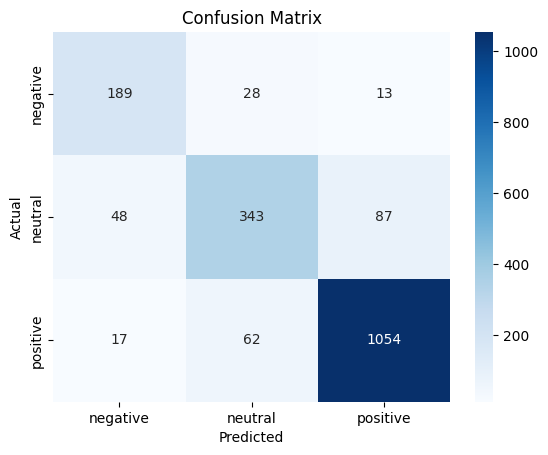

In [12]:
predictions = trainer.predict(tokenized["test"])
preds = np.argmax(predictions.predictions, axis=-1)
labels = predictions.label_ids

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Accuracy
print("Test Accuracy:", accuracy_score(labels, preds))

# Classification Report
print(classification_report(labels, preds, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(labels, preds)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## 3rd model

In [13]:
from transformers import AutoTokenizer
from datasets import Dataset

# ✅ Ensure all comments are strings
df["Comment"] = df["Comment"].astype(str)

# 🔄 Convert to Hugging Face Dataset
dataset = Dataset.from_pandas(df)
dataset = dataset.shuffle(seed=42)
dataset = dataset.train_test_split(test_size=0.1)

# ✅ Load tokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# 🧼 Tokenization function
def tokenize(batch):
    return tokenizer(batch["Comment"], padding=True, truncation=True)

# 🔄 Tokenize the dataset
tokenized = dataset.map(tokenize, batched=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/16567 [00:00<?, ? examples/s]

Map:   0%|          | 0/1841 [00:00<?, ? examples/s]

In [14]:
from transformers import AutoModelForSequenceClassification

num_labels = len(le.classes_)  # E.g. 3 for positive, neutral, negative

model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=num_labels
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
from transformers import TrainingArguments, Trainer
import evaluate

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return accuracy.compute(predictions=preds, references=labels)

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_dir="./logs",
    fp16=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/tmp/ipython-input-15-2358532530.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [16]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.384200,0.327989,0.875068
2,0.233900,0.370944,0.875068
3,0.148800,0.468509,0.880500


TrainOutput(global_step=3108, training_loss=0.2743255137783527, metrics={'train_runtime': 1462.723, 'train_samples_per_second': 33.978, 'train_steps_per_second': 2.125, 'total_flos': 1.3076999974499328e+16, 'train_loss': 0.2743255137783527, 'epoch': 3.0})

Test Accuracy: 0.8750678978815861
              precision    recall  f1-score   support

    negative       0.81      0.79      0.80       239
     neutral       0.76      0.76      0.76       431
    positive       0.93      0.94      0.93      1171

    accuracy                           0.88      1841
   macro avg       0.83      0.83      0.83      1841
weighted avg       0.87      0.88      0.87      1841



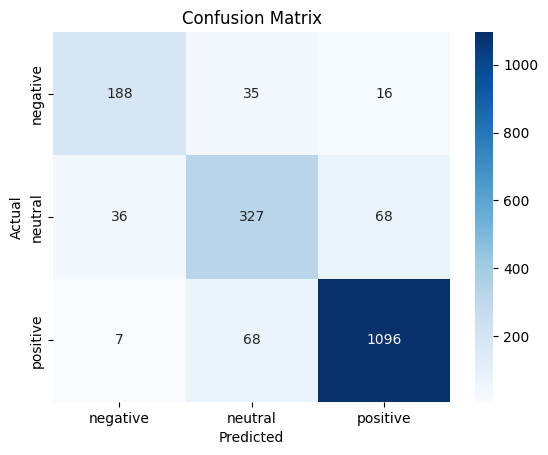

In [17]:
predictions = trainer.predict(tokenized["test"])
preds = np.argmax(predictions.predictions, axis=-1)
labels = predictions.label_ids

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Accuracy
print("Test Accuracy:", accuracy_score(labels, preds))

# Classification Report
print(classification_report(labels, preds, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(labels, preds)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## 1st model- stratify split

In [18]:
# 📥 Step 2: Load and prepare data
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load CSV
df = pd.read_csv("/root/.cache/kagglehub/datasets/atifaliak/youtube-comments-dataset/versions/1/YoutubeCommentsDataSet.csv")[["Comment", "Sentiment"]].dropna()

# Encode labels
le = LabelEncoder()
df["label"] = le.fit_transform(df["Sentiment"])
df["Comment"] = df["Comment"].astype(str)

# Stratified train-test split
train_df, test_df = train_test_split(
    df,
    test_size=0.1,
    stratify=df["label"],
    random_state=42,
)

In [19]:
# 📦 Step 3: Convert to Hugging Face Dataset
from datasets import Dataset

train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
test_ds = Dataset.from_pandas(test_df.reset_index(drop=True))

dataset = {"train": train_ds, "test": test_ds}

In [20]:
# 🧼 Step 4: Tokenize
from transformers import AutoTokenizer

model_name = "distilbert-base-uncased"  # You can change to distilbert-base-uncased, etc.

tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch["Comment"], padding=True, truncation=True)

tokenized = {k: v.map(tokenize, batched=True) for k, v in dataset.items()}

Map:   0%|          | 0/16527 [00:00<?, ? examples/s]

Map:   0%|          | 0/1837 [00:00<?, ? examples/s]

In [21]:
# 🤖 Step 5: Load model
from transformers import AutoModelForSequenceClassification

num_labels = len(le.classes_)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
# ⚙️ Step 6: Training setup
from transformers import TrainingArguments, Trainer
import numpy as np
import evaluate

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return accuracy.compute(predictions=preds, references=labels)

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_dir="./logs",
    fp16=True,
)

In [23]:
# 🏋️ Step 7: Trainer initialization and training
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

/tmp/ipython-input-23-3097825875.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.483500,0.378368,0.840501
2,0.298600,0.343430,0.855743
3,0.207700,0.366649,0.856832


TrainOutput(global_step=1551, training_loss=0.3261572808930368, metrics={'train_runtime': 695.1567, 'train_samples_per_second': 71.323, 'train_steps_per_second': 2.231, 'total_flos': 6567983221330944.0, 'train_loss': 0.3261572808930368, 'epoch': 3.0})

Test Accuracy: 0.8557430593358737
              precision    recall  f1-score   support

    negative       0.79      0.76      0.78       234
     neutral       0.72      0.77      0.74       463
    positive       0.93      0.91      0.92      1140

    accuracy                           0.86      1837
   macro avg       0.81      0.81      0.81      1837
weighted avg       0.86      0.86      0.86      1837



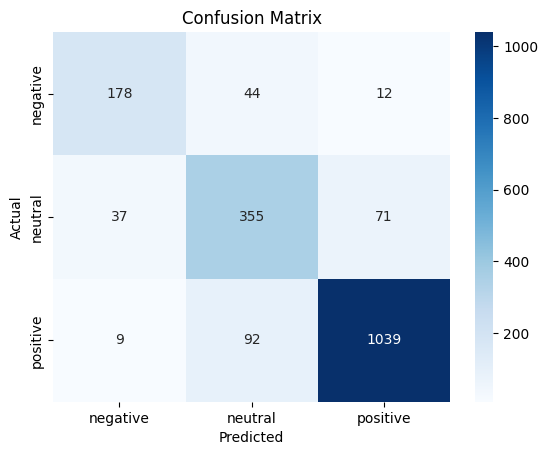

In [24]:
# 📊 Step 8: Evaluate model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions
predictions = trainer.predict(tokenized["test"])
preds = np.argmax(predictions.predictions, axis=-1)
labels = predictions.label_ids

# Accuracy
print("Test Accuracy:", accuracy_score(labels, preds))

# Classification Report
print(classification_report(labels, preds, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(labels, preds)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## 3rd model - stratify split

In [25]:
# 📥 Step 2: Load and prepare data
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load CSV
df = pd.read_csv("/root/.cache/kagglehub/datasets/atifaliak/youtube-comments-dataset/versions/1/YoutubeCommentsDataSet.csv")[["Comment", "Sentiment"]].dropna()

# Encode labels
le = LabelEncoder()
df["label"] = le.fit_transform(df["Sentiment"])
df["Comment"] = df["Comment"].astype(str)

# Stratified train-test split
train_df, test_df = train_test_split(
    df,
    test_size=0.1,
    stratify=df["label"],
    random_state=42,
)

In [26]:
# 📦 Step 3: Convert to Hugging Face Dataset
from datasets import Dataset

train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
test_ds = Dataset.from_pandas(test_df.reset_index(drop=True))

dataset = {"train": train_ds, "test": test_ds}

In [27]:
# 🧼 Step 4: Tokenize
from transformers import AutoTokenizer

model_name = "bert-base-uncased"  # You can change to distilbert-base-uncased, etc.

tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch["Comment"], padding=True, truncation=True)

tokenized = {k: v.map(tokenize, batched=True) for k, v in dataset.items()}

Map:   0%|          | 0/16527 [00:00<?, ? examples/s]

Map:   0%|          | 0/1837 [00:00<?, ? examples/s]

In [28]:
# 🤖 Step 5: Load model
from transformers import AutoModelForSequenceClassification

num_labels = len(le.classes_)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
# ⚙️ Step 6: Training setup
from transformers import TrainingArguments, Trainer
import numpy as np
import evaluate

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return accuracy.compute(predictions=preds, references=labels)

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_dir="./logs",
    fp16=True,
)

In [30]:
# 🏋️ Step 7: Trainer initialization and training
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

/tmp/ipython-input-30-3097825875.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.462400,0.366268,0.853566
2,0.251100,0.336255,0.867719
3,0.155200,0.381230,0.872074


TrainOutput(global_step=1551, training_loss=0.2852208170100691, metrics={'train_runtime': 1318.4142, 'train_samples_per_second': 37.607, 'train_steps_per_second': 1.176, 'total_flos': 1.3045426364371968e+16, 'train_loss': 0.2852208170100691, 'epoch': 3.0})

Test Accuracy: 0.8677191072400653
              precision    recall  f1-score   support

    negative       0.77      0.83      0.80       234
     neutral       0.75      0.78      0.76       463
    positive       0.94      0.91      0.93      1140

    accuracy                           0.87      1837
   macro avg       0.82      0.84      0.83      1837
weighted avg       0.87      0.87      0.87      1837



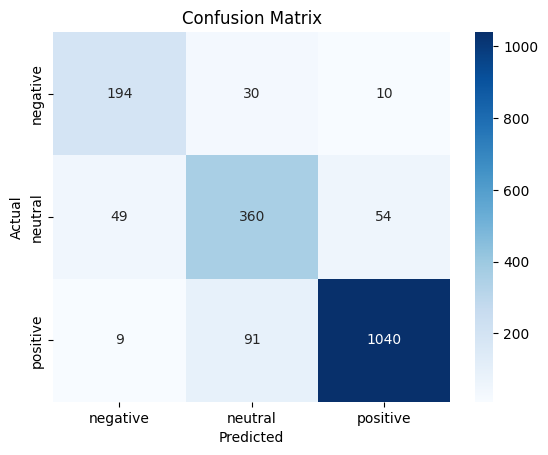

In [31]:
# 📊 Step 8: Evaluate model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions
predictions = trainer.predict(tokenized["test"])
preds = np.argmax(predictions.predictions, axis=-1)
labels = predictions.label_ids

# Accuracy
print("Test Accuracy:", accuracy_score(labels, preds))

# Classification Report
print(classification_report(labels, preds, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(labels, preds)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [32]:
import torch
from transformers import AutoModelForSequenceClassification, Trainer
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from scipy.special import softmax

# Paths to your saved models
checkpoint_paths = [
    "./results/checkpoint-1036",
    "./results/checkpoint-1551",
    "./results/checkpoint-3108"
]

# Load models
models = [AutoModelForSequenceClassification.from_pretrained(path).to("cuda") for path in checkpoint_paths]

# Dummy Trainer instance to reuse tokenizer and args
trainer = Trainer(model=models[0], tokenizer=tokenizer)

# Predict with all models
logits_list = []

for model in models:
    trainer.model = model
    trainer.model.eval()

    # Make predictions (Hugging Face handles batching, device automatically)
    output = trainer.predict(tokenized["test"])

    # Move logits to CPU to avoid device mismatch
    logits_cpu = torch.tensor(output.predictions).cpu().numpy()
    logits_list.append(logits_cpu)

# Soft-voting: average logits
avg_logits = np.mean(logits_list, axis=0)

# Final predictions
ensemble_preds = np.argmax(avg_logits, axis=1)

# True labels
true_labels = tokenized["test"]["label"]

# Evaluate
print("✅ Ensemble Accuracy:", accuracy_score(true_labels, ensemble_preds))
print(classification_report(true_labels, ensemble_preds, target_names=le.classes_))


/tmp/ipython-input-32-3776537304.py:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=models[0], tokenizer=tokenizer)


✅ Ensemble Accuracy: 0.9471965160587915
              precision    recall  f1-score   support

    negative       0.93      0.95      0.94       234
     neutral       0.90      0.90      0.90       463
    positive       0.97      0.97      0.97      1140

    accuracy                           0.95      1837
   macro avg       0.93      0.94      0.94      1837
weighted avg       0.95      0.95      0.95      1837



✅ Soft Voting Ensemble Accuracy: 0.9471965160587915

🔍 Classification Report:
              precision    recall  f1-score   support

    negative       0.93      0.95      0.94       234
     neutral       0.90      0.90      0.90       463
    positive       0.97      0.97      0.97      1140

    accuracy                           0.95      1837
   macro avg       0.93      0.94      0.94      1837
weighted avg       0.95      0.95      0.95      1837



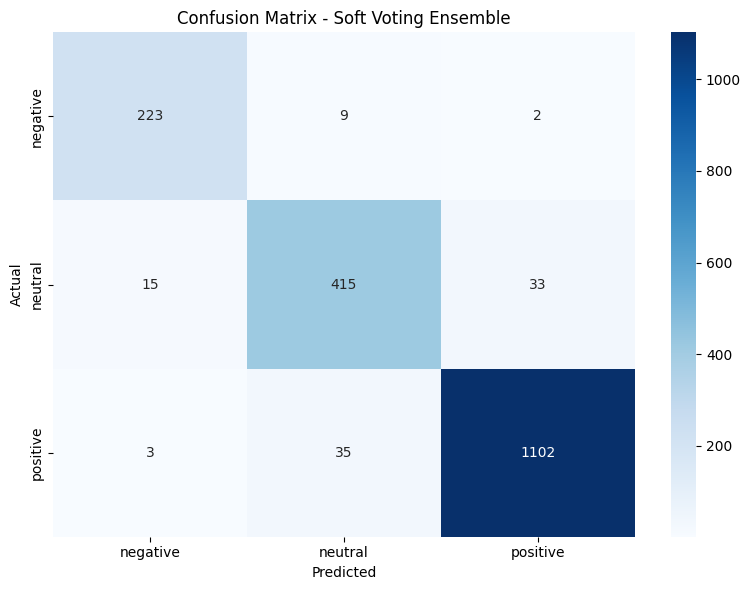

In [33]:
# 📊 Step 8: Evaluate Ensemble Model (Soft Voting)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- Step 1: Soft Voting Prediction ---
# Already computed earlier:
# avg_logits = np.mean(logits_list, axis=0)
ensemble_preds = np.argmax(avg_logits, axis=1)  # shape: (num_samples,)
labels = np.array(tokenized["test"]["label"])   # true labels

# --- Step 2: Accuracy ---
print("✅ Soft Voting Ensemble Accuracy:", accuracy_score(labels, ensemble_preds))

# --- Step 3: Classification Report ---
print("\n🔍 Classification Report:")
print(classification_report(labels, ensemble_preds, target_names=le.classes_))

# --- Step 4: Confusion Matrix ---
cm = confusion_matrix(labels, ensemble_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Soft Voting Ensemble")
plt.tight_layout()
plt.show()


In [34]:
!zip -r selected_checkpoints.zip \
    results/checkpoint-1036 \
    results/checkpoint-1551 \
    results/checkpoint-3108

  adding: results/checkpoint-1036/ (stored 0%)
  adding: results/checkpoint-1036/training_args.bin (deflated 52%)
  adding: results/checkpoint-1036/tokenizer.json (deflated 71%)
  adding: results/checkpoint-1036/special_tokens_map.json (deflated 42%)
  adding: results/checkpoint-1036/scaler.pt (deflated 60%)
  adding: results/checkpoint-1036/optimizer.pt (deflated 16%)
  adding: results/checkpoint-1036/vocab.txt (deflated 53%)
  adding: results/checkpoint-1036/scheduler.pt (deflated 56%)
  adding: results/checkpoint-1036/tokenizer_config.json (deflated 75%)
  adding: results/checkpoint-1036/rng_state.pth (deflated 25%)
  adding: results/checkpoint-1036/config.json (deflated 51%)
  adding: results/checkpoint-1036/model.safetensors (deflated 7%)
  adding: results/checkpoint-1036/trainer_state.json (deflated 59%)
  adding: results/checkpoint-1551/ (stored 0%)
  adding: results/checkpoint-1551/training_args.bin (deflated 51%)
  adding: results/checkpoint-1551/tokenizer.json (deflated 71%)


In [35]:
from google.colab import files
files.download("selected_checkpoints.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>